<a href="https://colab.research.google.com/github/qkrwoghd04/Image-text_fusion_for_binary_classification_using_BERT-ViT/blob/master/vit_classification_using_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch
!pip install torchinfo
!pip install ray
!pip install -U tensorboardx

In [2]:
!pip install timm

In [3]:
import os
import sys
import tempfile
import timm
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform
import pandas as pd
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.io import read_image
# Image Classification
import torch
from torchvision.transforms import v2
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import argparse
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
from torchinfo import summary
from functools import partial
import os
from pathlib import Path
import torchvision.transforms as transforms
from ray import tune
from ray import train
from ray.train import Checkpoint, get_checkpoint, Result
from ray.tune.schedulers import ASHAScheduler
from ray.tune.examples.mnist_pytorch import train_mnist
from ray.tune import ResultGrid,CLIReporter
import ray.cloudpickle as pickle
from PIL import Image

In [4]:
# Training device:
device = 'cuda'

# hyperparameter
learning_rate = 1e-4
batch_size = 64
epochs = 20
# based on paper's "attention is all you need"
BATCH_SIZE = 64
PATCH_SIZE = 16
IMAGE_WIDTH = 224
IMAGE_HEIGHT = IMAGE_WIDTH
IMAGE_CHANNELS = 3
EMBEDDING_DIMS = IMAGE_CHANNELS * PATCH_SIZE**2 #(3 * 16 * 16) = 768
NUM_OF_PATCHES = int((IMAGE_WIDTH * IMAGE_HEIGHT) / PATCH_SIZE**2) #((224*224)/

In [5]:
class CustomImageDataset():
  def __init__(self, csv_file, img_dir, transform=None, target_transform=None):
        self.img_file = pd.read_csv(os.path.join(img_dir, csv_file))
        self.csv_file = csv_file
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

  def __len__(self):
    return len(self.img_file)

  def __getitem__(self, index):
    # 레이블을 기반으로 서브폴더 경로 결정
    label = self.img_file.iloc[index, 2]
    subfolder = 'Sleep' if label == 'Sleep' else 'Fall'
    if "train" in self.csv_file:
      img_path = os.path.join(self.img_dir, 'train', subfolder, self.img_file.iloc[index, 0])

    elif "test" in self.csv_file:
      img_path = os.path.join(self.img_dir, 'test', subfolder, self.img_file.iloc[index, 0])
    if(label == "Sleep"):
       label = 0
    else: label = 1
    image = read_image(img_path)
    if self.transform:
        image = self.transform(image)
    if self.target_transform:
        label = self.target_transform(label)

    return image, label

In [6]:
def image_transform():
  transforms = v2.Compose([
      v2.Resize((224, 224)),
      v2.RandomHorizontalFlip(p=0.2),
      v2.ToDtype(torch.float32, scale=True),
      v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  ])


  return transforms

def test_img_transform():
  resize_transforms = v2.Compose([
      v2.Resize((224,224)),
      v2.ToDtype(torch.float32, scale=True),
      v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  ])

  return resize_transforms

def visualize_data(train_dataloader):
    # 이미지와 정답(label)을 표시합니다.
    train_features, train_labels = next(iter(train_dataloader))
    print(len(train_features))
    print(f"Feature batch shape: {train_features.size()}")
    print(f"Labels batch shape: {train_labels.size()}")
    img = train_features[0].squeeze()
    label = train_labels[0]

    if img.dim() == 3 and img.size(0) == 3:
        img = img.permute(1, 2, 0)

    plt.imshow(img, cmap="gray")
    plt.show()
    print(f"Label: {label}")

In [7]:
class PatchEmbeddingLayer(nn.Module):
    def __init__(self, in_channels, patch_size, embedding_dim):
        super().__init__()
        self.patch_size = patch_size
        self.embedding_dim = embedding_dim
        self.in_channels = in_channels
        self.conv_layer = nn.Conv2d(in_channels=in_channels,
                                    out_channels=embedding_dim, kernel_size=patch_size, stride=patch_size)
        self.flatten_layer = nn.Flatten(start_dim=1, end_dim=2)
        self.class_token_embeddings = nn.Parameter(torch.randn(1, 1, embedding_dim), requires_grad=True)
        self.position_embeddings = nn.Parameter(torch.randn(1, NUM_OF_PATCHES + 1, embedding_dim), requires_grad=True)

    def forward(self, x):
        batch_size = x.size(0)
        class_token_embeddings = self.class_token_embeddings.repeat(batch_size, 1, 1)
        x = self.conv_layer(x)
        x = x.permute(0, 2, 3, 1)
        x = self.flatten_layer(x)
        x = torch.cat((class_token_embeddings, x), dim=1)
        x = x + self.position_embeddings
        return x

In [8]:
class MultiHeadSelfAttentionBlock(nn.Module):
    def __init__(self, embedding_dims = 768, num_heads = 12, attn_dropout=0.0):
        super().__init__()
        self.embedding_dims = embedding_dims
        self.num_head = num_heads
        self.attn_dropout = attn_dropout
        self.layernorm = nn.LayerNorm(normalized_shape = embedding_dims)
        self.multiheadattention = nn.MultiheadAttention(num_heads = num_heads,
                                                        embed_dim = embedding_dims,
                                                        dropout = attn_dropout,
                                                        batch_first = True,
                                                        )
    def forward(self, x):
        x = self.layernorm(x)
        output,_ = self.multiheadattention(query=x, key=x, value=x, need_weights=False)
        return output

In [9]:
class MachineLearningPerceptronBlock(nn.Module):
    def __init__(self, embedding_dims, mlp_size, mlp_dropout):
        super().__init__()
        self.embedding_dims = embedding_dims
        self.mlp_size = mlp_size
        self.mlp_dropout = mlp_dropout

        self.layernorm = nn.LayerNorm(normalized_shape = embedding_dims)
        self.mlp = nn.Sequential(
            nn.Linear(in_features = embedding_dims, out_features = mlp_size),
            nn.GELU(),
            nn.Dropout(p = mlp_dropout),
            nn.Linear(in_features = mlp_size, out_features = embedding_dims),
            nn.Dropout(p = mlp_dropout)
        )
    def forward(self,x):
        return self.mlp(self.layernorm(x))

In [10]:
class TransformerBlock(nn.Module):
    def __init__(self, embedding_dims = 768,
                 mlp_dropout=0.1,
                 attn_dropout = 0.0,
                 mlp_size = 3072,
                 num_heads = 12,
                 ):
        super().__init__()

        self.mas_block = MultiHeadSelfAttentionBlock(embedding_dims = embedding_dims, num_heads = num_heads, attn_dropout=attn_dropout,)

        self.mlp_block = MachineLearningPerceptronBlock(embedding_dims=embedding_dims, mlp_size=mlp_size, mlp_dropout=mlp_dropout,)
    def forward(self, x):
        x = self.mas_block(x) + x
        x = self.mlp_block(x) + x
        return x

In [11]:
class vit_model(nn.Module):
    def __init__(self, img_size = 224, in_channels = 3, patch_size = 16, embedding_dims = 768, num_transformer_layers = 12, mlp_dropout = 0.1, attn_dropout = 0.0, mlp_size = 3072, num_heads = 12, num_classes = 2):
        super().__init__()

        self.patch_embedding_layer = PatchEmbeddingLayer(in_channels=in_channels, patch_size=patch_size, embedding_dim=embedding_dims)

        self.transformer_encoder = nn.Sequential(*[TransformerBlock(embedding_dims = embedding_dims, mlp_dropout=mlp_dropout, attn_dropout=attn_dropout, mlp_size=mlp_size, num_heads=num_heads) for _ in range(num_transformer_layers)])
        self.classifier = nn.Sequential(nn.LayerNorm(normalized_shape = embedding_dims), nn.Linear(in_features = embedding_dims, out_features = num_classes))
    def forward(self, x):
        return self.classifier(self.transformer_encoder(self.patch_embedding_layer(x))[:, 0])


In [12]:
def train_loop(dataloader, model, loss_fn, optimizer):
    for epoch in range(epochs):
        epoch_loss = 0
        epoch_accuracy = 0
        for data, label in tqdm(dataloader):
            data = data.to(device)
            label = label.to(device)

            output = model(data)
            loss = loss_fn(output, label)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            acc = (output.argmax(dim=1) == label).float().mean()
            epoch_accuracy += acc / len(dataloader)
            epoch_loss += loss / len(dataloader)

        print(
            f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f}\n"
        )

In [13]:
file_path = r"/content/drive/MyDrive/image_dataset/processed/"
train_data_csv = "train_captions.csv"
test_data_csv = "test_captions.csv"
transform = image_transform()
test_transform = test_img_transform()
train_dataset = CustomImageDataset(csv_file=train_data_csv, img_dir=file_path, transform=transform,)
# 트레이닝과 검증 데이터셋 크기 계산
total_train = len(train_dataset)
val_size = int(0.20 * total_train)
train_size = total_train - val_size

# 데이터셋 분할
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])
test_dataset = CustomImageDataset(csv_file=test_data_csv, img_dir=file_path, transform=test_transform)

train_dataloader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=1)
val_dataloader = DataLoader(val_subset, batch_size=batch_size, shuffle=True, num_workers=1)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


64
Feature batch shape: torch.Size([64, 3, 224, 224])
Labels batch shape: torch.Size([64])


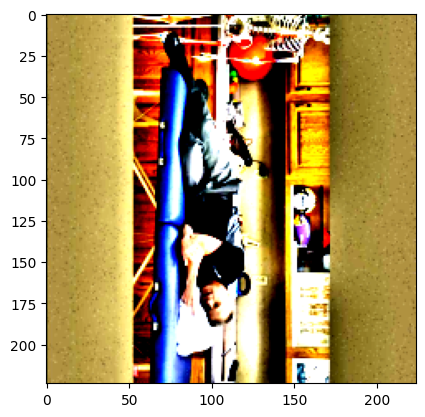

Label: 0


In [14]:
visualize_data(train_dataloader)

40
Feature batch shape: torch.Size([40, 3, 224, 224])
Labels batch shape: torch.Size([40])


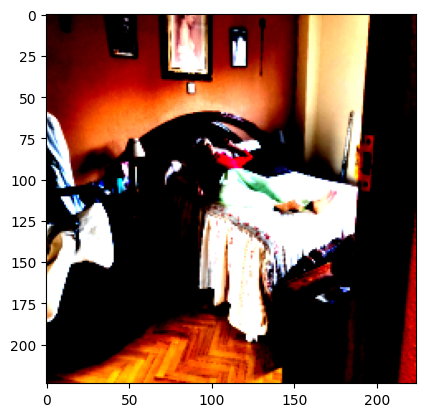

Label: 0


In [15]:
visualize_data(test_dataloader)

In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# model = vit_model().to(device)
# summary(model, input_size=(batch_size, IMAGE_CHANNELS, IMAGE_WIDTH, IMAGE_HEIGHT))
model = timm.create_model('vit_base_patch16_224', pretrained=True)
config = resolve_data_config({}, model=model)
transform = create_transform(**config)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [17]:
summary(model, input_size=(batch_size, IMAGE_CHANNELS, IMAGE_WIDTH, IMAGE_HEIGHT))

Layer (type:depth-idx)                   Output Shape              Param #
VisionTransformer                        [64, 1000]                152,064
├─PatchEmbed: 1-1                        [64, 196, 768]            --
│    └─Conv2d: 2-1                       [64, 768, 14, 14]         590,592
│    └─Identity: 2-2                     [64, 196, 768]            --
├─Dropout: 1-2                           [64, 197, 768]            --
├─Identity: 1-3                          [64, 197, 768]            --
├─Identity: 1-4                          [64, 197, 768]            --
├─Sequential: 1-5                        [64, 197, 768]            --
│    └─Block: 2-3                        [64, 197, 768]            --
│    │    └─LayerNorm: 3-1               [64, 197, 768]            1,536
│    │    └─Attention: 3-2               [64, 197, 768]            2,362,368
│    │    └─Identity: 3-3                [64, 197, 768]            --
│    │    └─Identity: 3-4                [64, 197, 768]          

In [18]:
CHECKPOINT_FREQ = 3
CHECKPOINT_DIR = "./drive/MyDrive/ray_results/tune_analyzing_results/checkpoints"  # 영구 저장소 경로 설정

def train_func(config):
  start = 1
  device = "cuda" if torch.cuda.is_available() else "cpu"
  # model = vit_model().to(device)
  model = timm.create_model('vit_base_patch16_224', pretrained=True)
  model.to("cuda")
  model_config = resolve_data_config({}, model=model)
  transform = create_transform(**model_config)
  loss_fn = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"])

  # #Define checkpoint
  checkpoint = train.get_checkpoint()
  if checkpoint:
      with checkpoint.as_directory() as checkpoint_dir:
          checkpoint_dict = torch.load(os.path.join(checkpoint_dir, "checkpoint.pt"))
          print(checkpoint_dict)
          start = checkpoint_dict["epoch"] + 1
          model.load_state_dict(checkpoint_dict["model_state"])

  train_dataloader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=1)
  val_dataloader = DataLoader(val_subset, batch_size=batch_size, shuffle=True, num_workers=1)

  #model training
  for epoch in range(start, config["epochs"] + 1):  # loop over the dataset multiple times
      running_loss = 0.0
      epoch_steps = 0
      for i, data in enumerate(train_dataloader, 0):
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data
          inputs, labels = inputs.to(device), labels.to(device)

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = model(inputs)
          loss = loss_fn(outputs, labels)
          loss.backward()
          optimizer.step()

          # print statistics
          running_loss += loss.item()
          epoch_steps += 1
          if i % 2000 == 1999:  # print every 2000 mini-batches
              print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1,
                                                running_loss / epoch_steps))
              running_loss = 0.0

      # Validation loss
      val_loss = 0.0
      val_steps = 0
      total = 0
      correct = 0
      for i, data in enumerate(val_dataloader, 0):
          with torch.no_grad():
              inputs, labels = data
              inputs, labels = inputs.to(device), labels.to(device)

              outputs = model(inputs)
              _, predicted = torch.max(outputs.data, 1)
              total += labels.size(0)
              correct += (predicted == labels).sum().item()

              loss = loss_fn(outputs, labels)
              val_loss += loss.cpu().numpy()
              val_steps += 1
      metrics = {
            "loss": running_loss / len(train_dataloader),
            "val_loss": val_loss / len(val_dataloader),
            "mean_accuracy": correct / total
      }
      with tempfile.TemporaryDirectory() as tempdir:
          print(os.path.join(tempdir, "checkpoint.pt"))
          torch.save(
              {"epoch": epoch, "model_state": model.state_dict()},
              os.path.join(tempdir, "checkpoint.pt"),
          )
          train.report(metrics=metrics, checkpoint=Checkpoint.from_directory(tempdir))

In [19]:
def test_accuracy(model, device="cpu"):
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=1)
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_dataloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

In [23]:
storage_path = "/content/drive/MyDrive/ray_results"
exp_name = "tune_analyzing_results"
trainable_with_resources = tune.with_resources(train_func, {"cpu":4 , "gpu":1, "accelerator_type:T4":1})
scheduler = ASHAScheduler(
        max_t=10,
        grace_period=1,
        reduction_factor=2)
tuner = tune.Tuner(
    trainable_with_resources,
    param_space={
        "lr": tune.loguniform(1e-4 , 4e-4, 1e-5),
        "batch_size": tune.choice([16, 32, 64]),
        "epochs": 10,
        "should_checkpoint":True,
    },
    run_config=train.RunConfig(
        name=exp_name,
        # stop={"training_iteration": 3},
        checkpoint_config=train.CheckpointConfig(
            checkpoint_score_attribute="mean_accuracy",
            num_to_keep=3
        ),
        storage_path=storage_path,
    ),
    tune_config=tune.TuneConfig(mode="min", metric="val_loss", num_samples=8, max_concurrent_trials=2, scheduler=scheduler),
)
result_grid: ResultGrid = tuner.fit()


+-----------------------------------------------------------+
| Configuration for experiment     tune_analyzing_results   |
+-----------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator    |
| Scheduler                        AsyncHyperBandScheduler  |
| Number of trials                 8                        |
+-----------------------------------------------------------+

View detailed results here: /content/drive/MyDrive/ray_results/tune_analyzing_results
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2024-05-07_14-33-35_603960_48572/artifacts/2024-05-07_14-38-43/tune_analyzing_results/driver_artifacts`

Trial status: 2 PENDING
Current time: 2024-05-07 14:38:44. Total running time: 0s
Logical resource usage: 4.0/8 CPUs, 1.0/1 GPUs (1.0/1.0 accelerator_type:T4)
+----------------------------------------------------------------+
| Trial name               status              lr     batch_

(train_func pid=51179) /usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
(train_func pid=51179)   self.pid = os.fork()


(train_func pid=51179) /tmp/tmp888tk8xs/checkpoint.pt


(train_func pid=51179) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/drive/MyDrive/ray_results/tune_analyzing_results/train_func_80fed_00000_0_batch_size=16,lr=0.0002_2024-05-07_14-38-43/checkpoint_000000)



Trial status: 1 RUNNING | 1 PENDING
Current time: 2024-05-07 14:39:14. Total running time: 30s
Logical resource usage: 4.0/8 CPUs, 1.0/1 GPUs (1.0/1.0 accelerator_type:T4)
Current best trial: 80fed_00000 with val_loss=1.4132618308067322 and params={'lr': 0.0002385889256198421, 'batch_size': 16, 'epochs': 10, 'should_checkpoint': True}
+---------------------------------------------------------------------------------------------------------------------------+
| Trial name               status              lr     batch_size     acc     iter     total time (s)      loss     val_loss |
+---------------------------------------------------------------------------------------------------------------------------+
| train_func_80fed_00000   RUNNING    0.000238589             16     0.5        1            16.9425   4.31052      1.41326 |
| train_func_80fed_00001   PENDING    0.000181062             64                                                            |
+-------------------------------

(train_func pid=51179) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/drive/MyDrive/ray_results/tune_analyzing_results/train_func_80fed_00000_0_batch_size=16,lr=0.0002_2024-05-07_14-38-43/checkpoint_000001)


(train_func pid=51179) /tmp/tmpp47epn6z/checkpoint.pt


(train_func pid=51179) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/drive/MyDrive/ray_results/tune_analyzing_results/train_func_80fed_00000_0_batch_size=16,lr=0.0002_2024-05-07_14-38-43/checkpoint_000002)


Trial status: 1 RUNNING | 1 PENDING
Current time: 2024-05-07 14:39:44. Total running time: 1min 0s
Logical resource usage: 4.0/8 CPUs, 1.0/1 GPUs (1.0/1.0 accelerator_type:T4)
Current best trial: 80fed_00000 with val_loss=0.5033270865678787 and params={'lr': 0.0002385889256198421, 'batch_size': 16, 'epochs': 10, 'should_checkpoint': True}
+-----------------------------------------------------------------------------------------------------------------------------+
| Trial name               status              lr     batch_size      acc     iter     total time (s)       loss     val_loss |
+-----------------------------------------------------------------------------------------------------------------------------+
| train_func_80fed_00000   RUNNING    0.000238589             16   0.7375        3            49.8981   0.672756     0.503327 |
| train_func_80fed_00001   PENDING    0.000181062             64                                                              |
+------------------

(train_func pid=51179) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/drive/MyDrive/ray_results/tune_analyzing_results/train_func_80fed_00000_0_batch_size=16,lr=0.0002_2024-05-07_14-38-43/checkpoint_000003)


(train_func pid=51179) /tmp/tmpjvgfysm4/checkpoint.pt


(train_func pid=51179) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/drive/MyDrive/ray_results/tune_analyzing_results/train_func_80fed_00000_0_batch_size=16,lr=0.0002_2024-05-07_14-38-43/checkpoint_000004)


Trial status: 1 RUNNING | 1 PENDING
Current time: 2024-05-07 14:40:14. Total running time: 1min 30s
Logical resource usage: 4.0/8 CPUs, 1.0/1 GPUs (1.0/1.0 accelerator_type:T4)
Current best trial: 80fed_00000 with val_loss=0.538155734539032 and params={'lr': 0.0002385889256198421, 'batch_size': 16, 'epochs': 10, 'should_checkpoint': True}
+-----------------------------------------------------------------------------------------------------------------------------+
| Trial name               status              lr     batch_size      acc     iter     total time (s)       loss     val_loss |
+-----------------------------------------------------------------------------------------------------------------------------+
| train_func_80fed_00000   RUNNING    0.000238589             16   0.6875        5            82.4267   0.533975     0.538156 |
| train_func_80fed_00001   PENDING    0.000181062             64                                                              |
+------------------

(train_func pid=51179) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/drive/MyDrive/ray_results/tune_analyzing_results/train_func_80fed_00000_0_batch_size=16,lr=0.0002_2024-05-07_14-38-43/checkpoint_000005)


(train_func pid=51179) /tmp/tmpzixfz_39/checkpoint.pt


(train_func pid=51179) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/drive/MyDrive/ray_results/tune_analyzing_results/train_func_80fed_00000_0_batch_size=16,lr=0.0002_2024-05-07_14-38-43/checkpoint_000006)


Trial status: 1 RUNNING | 1 PENDING
Current time: 2024-05-07 14:40:44. Total running time: 2min 0s
Logical resource usage: 4.0/8 CPUs, 1.0/1 GPUs (1.0/1.0 accelerator_type:T4)
Current best trial: 80fed_00000 with val_loss=0.3555372953414917 and params={'lr': 0.0002385889256198421, 'batch_size': 16, 'epochs': 10, 'should_checkpoint': True}
+----------------------------------------------------------------------------------------------------------------------------+
| Trial name               status              lr     batch_size      acc     iter     total time (s)      loss     val_loss |
+----------------------------------------------------------------------------------------------------------------------------+
| train_func_80fed_00000   RUNNING    0.000238589             16   0.8375        7            115.196   0.42692     0.355537 |
| train_func_80fed_00001   PENDING    0.000181062             64                                                             |
+-----------------------

(train_func pid=51179) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/drive/MyDrive/ray_results/tune_analyzing_results/train_func_80fed_00000_0_batch_size=16,lr=0.0002_2024-05-07_14-38-43/checkpoint_000007)


Trial status: 1 RUNNING | 1 PENDING
Current time: 2024-05-07 14:41:14. Total running time: 2min 30s
Logical resource usage: 4.0/8 CPUs, 1.0/1 GPUs (1.0/1.0 accelerator_type:T4)
Current best trial: 80fed_00000 with val_loss=0.28569020330905914 and params={'lr': 0.0002385889256198421, 'batch_size': 16, 'epochs': 10, 'should_checkpoint': True}
+----------------------------------------------------------------------------------------------------------------------------+
| Trial name               status              lr     batch_size     acc     iter     total time (s)       loss     val_loss |
+----------------------------------------------------------------------------------------------------------------------------+
| train_func_80fed_00000   RUNNING    0.000238589             16     0.9        8            131.984   0.353265      0.28569 |
| train_func_80fed_00001   PENDING    0.000181062             64                                                             |
+---------------------

(train_func pid=51179) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/drive/MyDrive/ray_results/tune_analyzing_results/train_func_80fed_00000_0_batch_size=16,lr=0.0002_2024-05-07_14-38-43/checkpoint_000008)


(train_func pid=51179) /tmp/tmpua2ssp3v/checkpoint.pt

Trial train_func_80fed_00000 completed after 10 iterations at 2024-05-07 14:41:33. Total running time: 2min 50s
+-----------------------------------------------------------+
| Trial train_func_80fed_00000 result                       |
+-----------------------------------------------------------+
| checkpoint_dir_name                     checkpoint_000009 |
| time_this_iter_s                                  16.5031 |
| time_total_s                                    165.20917 |
| training_iteration                                     10 |
| loss                                              0.22066 |
| mean_accuracy                                       0.925 |
| val_loss                                          0.14901 |
+-----------------------------------------------------------+


(train_func pid=51179) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/drive/MyDrive/ray_results/tune_analyzing_results/train_func_80fed_00000_0_batch_size=16,lr=0.0002_2024-05-07_14-38-43/checkpoint_000009)



Trial train_func_80fed_00001 started with configuration:
+-------------------------------------------------+
| Trial train_func_80fed_00001 config             |
+-------------------------------------------------+
| batch_size                                   64 |
| epochs                                       10 |
| lr                                      0.00018 |
| should_checkpoint                             1 |
+-------------------------------------------------+


(train_func pid=52200) /usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
(train_func pid=52200)   self.pid = os.fork()



Trial status: 1 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2024-05-07 14:41:44. Total running time: 3min 0s
Logical resource usage: 4.0/8 CPUs, 1.0/1 GPUs (1.0/1.0 accelerator_type:T4)
Current best trial: 80fed_00000 with val_loss=0.1490136757493019 and params={'lr': 0.0002385889256198421, 'batch_size': 16, 'epochs': 10, 'should_checkpoint': True}
+------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status                lr     batch_size     acc     iter     total time (s)       loss     val_loss |
+------------------------------------------------------------------------------------------------------------------------------+
| train_func_80fed_00001   RUNNING      0.000181062             64                                                             |
| train_func_80fed_00000   TERMINATED   0.000238589             16   0.925       10            165.209   0.220661     0.149014 

(train_func pid=52200) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/drive/MyDrive/ray_results/tune_analyzing_results/train_func_80fed_00001_1_batch_size=64,lr=0.0002_2024-05-07_14-38-43/checkpoint_000000)


(train_func pid=52200) /tmp/tmpn5ndyegw/checkpoint.pt


(train_func pid=52200) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/drive/MyDrive/ray_results/tune_analyzing_results/train_func_80fed_00001_1_batch_size=64,lr=0.0002_2024-05-07_14-38-43/checkpoint_000001)


Trial status: 1 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2024-05-07 14:42:14. Total running time: 3min 30s
Logical resource usage: 4.0/8 CPUs, 1.0/1 GPUs (1.0/1.0 accelerator_type:T4)
Current best trial: 80fed_00000 with val_loss=0.1490136757493019 and params={'lr': 0.0002385889256198421, 'batch_size': 16, 'epochs': 10, 'should_checkpoint': True}
+-------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status                lr     batch_size      acc     iter     total time (s)       loss     val_loss |
+-------------------------------------------------------------------------------------------------------------------------------+
| train_func_80fed_00001   RUNNING      0.000181062             64   0.6125        2             32.483   0.848608     0.565333 |
| train_func_80fed_00000   TERMINATED   0.000238589             16   0.925        10            165.209   0.220661     0.14

(train_func pid=52200) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/drive/MyDrive/ray_results/tune_analyzing_results/train_func_80fed_00001_1_batch_size=64,lr=0.0002_2024-05-07_14-38-43/checkpoint_000002)


(train_func pid=52200) /tmp/tmpizqlpuf2/checkpoint.pt


(train_func pid=52200) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/drive/MyDrive/ray_results/tune_analyzing_results/train_func_80fed_00001_1_batch_size=64,lr=0.0002_2024-05-07_14-38-43/checkpoint_000003)


Trial status: 1 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2024-05-07 14:42:44. Total running time: 4min 0s
Logical resource usage: 4.0/8 CPUs, 1.0/1 GPUs (1.0/1.0 accelerator_type:T4)
Current best trial: 80fed_00000 with val_loss=0.1490136757493019 and params={'lr': 0.0002385889256198421, 'batch_size': 16, 'epochs': 10, 'should_checkpoint': True}
+-------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status                lr     batch_size      acc     iter     total time (s)       loss     val_loss |
+-------------------------------------------------------------------------------------------------------------------------------+
| train_func_80fed_00001   RUNNING      0.000181062             64   0.7625        4            64.4623   0.471612     0.440452 |
| train_func_80fed_00000   TERMINATED   0.000238589             16   0.925        10           165.209    0.220661     0.149

(train_func pid=52200) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/drive/MyDrive/ray_results/tune_analyzing_results/train_func_80fed_00001_1_batch_size=64,lr=0.0002_2024-05-07_14-38-43/checkpoint_000004)


Trial status: 1 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2024-05-07 14:43:14. Total running time: 4min 30s
Logical resource usage: 4.0/8 CPUs, 1.0/1 GPUs (1.0/1.0 accelerator_type:T4)
Current best trial: 80fed_00000 with val_loss=0.1490136757493019 and params={'lr': 0.0002385889256198421, 'batch_size': 16, 'epochs': 10, 'should_checkpoint': True}
+-------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status                lr     batch_size      acc     iter     total time (s)       loss     val_loss |
+-------------------------------------------------------------------------------------------------------------------------------+
| train_func_80fed_00001   RUNNING      0.000181062             64   0.9125        5            80.9802   0.367383     0.305864 |
| train_func_80fed_00000   TERMINATED   0.000238589             16   0.925        10           165.209    0.220661     0.14

(train_func pid=52200) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/drive/MyDrive/ray_results/tune_analyzing_results/train_func_80fed_00001_1_batch_size=64,lr=0.0002_2024-05-07_14-38-43/checkpoint_000005)


(train_func pid=52200) /tmp/tmp0qecw17h/checkpoint.pt


(train_func pid=52200) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/drive/MyDrive/ray_results/tune_analyzing_results/train_func_80fed_00001_1_batch_size=64,lr=0.0002_2024-05-07_14-38-43/checkpoint_000006)
2024-05-07 14:43:35,338	WARNING util.py:201 -- The `process_trial_save` operation took 1.709 s, which may be a performance bottleneck.


Trial status: 1 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2024-05-07 14:43:44. Total running time: 5min 0s
Logical resource usage: 4.0/8 CPUs, 1.0/1 GPUs (1.0/1.0 accelerator_type:T4)
Current best trial: 80fed_00000 with val_loss=0.1490136757493019 and params={'lr': 0.0002385889256198421, 'batch_size': 16, 'epochs': 10, 'should_checkpoint': True}
+------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status                lr     batch_size     acc     iter     total time (s)       loss     val_loss |
+------------------------------------------------------------------------------------------------------------------------------+
| train_func_80fed_00001   RUNNING      0.000181062             64   0.95         7            114.14    0.283061     0.191197 |
| train_func_80fed_00000   TERMINATED   0.000238589             16   0.925       10            165.209   0.220661     0.149014 |

(train_func pid=52200) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/drive/MyDrive/ray_results/tune_analyzing_results/train_func_80fed_00001_1_batch_size=64,lr=0.0002_2024-05-07_14-38-43/checkpoint_000007)


(train_func pid=52200) /tmp/tmptbax6wnh/checkpoint.pt


(train_func pid=52200) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/drive/MyDrive/ray_results/tune_analyzing_results/train_func_80fed_00001_1_batch_size=64,lr=0.0002_2024-05-07_14-38-43/checkpoint_000008)


Trial status: 1 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2024-05-07 14:44:14. Total running time: 5min 30s
Logical resource usage: 4.0/8 CPUs, 1.0/1 GPUs (1.0/1.0 accelerator_type:T4)
Current best trial: 80fed_00000 with val_loss=0.1490136757493019 and params={'lr': 0.0002385889256198421, 'batch_size': 16, 'epochs': 10, 'should_checkpoint': True}
+-------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status                lr     batch_size      acc     iter     total time (s)       loss     val_loss |
+-------------------------------------------------------------------------------------------------------------------------------+
| train_func_80fed_00001   RUNNING      0.000181062             64   0.9375        9            145.591   0.250894     0.201841 |
| train_func_80fed_00000   TERMINATED   0.000238589             16   0.925        10            165.209   0.220661     0.14

(train_func pid=52200) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/drive/MyDrive/ray_results/tune_analyzing_results/train_func_80fed_00001_1_batch_size=64,lr=0.0002_2024-05-07_14-38-43/checkpoint_000009)



Trial train_func_80fed_00002 started with configuration:
+-------------------------------------------------+
| Trial train_func_80fed_00002 config             |
+-------------------------------------------------+
| batch_size                                   64 |
| epochs                                       10 |
| lr                                      0.00014 |
| should_checkpoint                             1 |
+-------------------------------------------------+


(train_func pid=53217) /usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
(train_func pid=53217)   self.pid = os.fork()



Trial status: 2 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2024-05-07 14:44:44. Total running time: 6min 1s
Logical resource usage: 4.0/8 CPUs, 1.0/1 GPUs (1.0/1.0 accelerator_type:T4)
Current best trial: 80fed_00000 with val_loss=0.1490136757493019 and params={'lr': 0.0002385889256198421, 'batch_size': 16, 'epochs': 10, 'should_checkpoint': True}
+------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status                lr     batch_size     acc     iter     total time (s)       loss     val_loss |
+------------------------------------------------------------------------------------------------------------------------------+
| train_func_80fed_00002   RUNNING      0.000139915             64                                                             |
| train_func_80fed_00000   TERMINATED   0.000238589             16   0.925       10            165.209   0.220661     0.149014 

(train_func pid=53217) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/drive/MyDrive/ray_results/tune_analyzing_results/train_func_80fed_00002_2_batch_size=64,lr=0.0001_2024-05-07_14-41-33/checkpoint_000000)



Trial train_func_80fed_00003 started with configuration:
+-------------------------------------------------+
| Trial train_func_80fed_00003 config             |
+-------------------------------------------------+
| batch_size                                   64 |
| epochs                                       10 |
| lr                                      0.00011 |
| should_checkpoint                             1 |
+-------------------------------------------------+


(train_func pid=53393) /usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
(train_func pid=53393)   self.pid = os.fork()


(train_func pid=53393) /tmp/tmp8i2vtrkj/checkpoint.pt


(train_func pid=53393) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/drive/MyDrive/ray_results/tune_analyzing_results/train_func_80fed_00003_3_batch_size=64,lr=0.0001_2024-05-07_14-44-22/checkpoint_000000)



Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2024-05-07 14:45:14. Total running time: 6min 31s
Logical resource usage: 4.0/8 CPUs, 1.0/1 GPUs (1.0/1.0 accelerator_type:T4)
Current best trial: 80fed_00000 with val_loss=0.1490136757493019 and params={'lr': 0.0002385889256198421, 'batch_size': 16, 'epochs': 10, 'should_checkpoint': True}
+------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status                lr     batch_size     acc     iter     total time (s)       loss     val_loss |
+------------------------------------------------------------------------------------------------------------------------------+
| train_func_80fed_00003   RUNNING      0.000105564             64   0.5          1            17.1223   3.0594       1.31941  |
| train_func_80fed_00000   TERMINATED   0.000238589             16   0.925       10           165.209    0.220661     0.149014

(train_func pid=53393) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/drive/MyDrive/ray_results/tune_analyzing_results/train_func_80fed_00003_3_batch_size=64,lr=0.0001_2024-05-07_14-44-22/checkpoint_000001)


(train_func pid=53393) /tmp/tmp0ksz6skn/checkpoint.pt


(train_func pid=53393) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/drive/MyDrive/ray_results/tune_analyzing_results/train_func_80fed_00003_3_batch_size=64,lr=0.0001_2024-05-07_14-44-22/checkpoint_000002)


Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2024-05-07 14:45:44. Total running time: 7min 1s
Logical resource usage: 4.0/8 CPUs, 1.0/1 GPUs (1.0/1.0 accelerator_type:T4)
Current best trial: 80fed_00003 with val_loss=0.12838029116392136 and params={'lr': 0.00010556379497097863, 'batch_size': 64, 'epochs': 10, 'should_checkpoint': True}
+-------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status                lr     batch_size      acc     iter     total time (s)       loss     val_loss |
+-------------------------------------------------------------------------------------------------------------------------------+
| train_func_80fed_00003   RUNNING      0.000105564             64   0.9625        3            52.0013   0.204483     0.12838  |
| train_func_80fed_00000   TERMINATED   0.000238589             16   0.925        10           165.209    0.220661     0.1

(train_func pid=53393) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/drive/MyDrive/ray_results/tune_analyzing_results/train_func_80fed_00003_3_batch_size=64,lr=0.0001_2024-05-07_14-44-22/checkpoint_000003)


(train_func pid=53393) /tmp/tmpxgecb3kh/checkpoint.pt


(train_func pid=53393) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/drive/MyDrive/ray_results/tune_analyzing_results/train_func_80fed_00003_3_batch_size=64,lr=0.0001_2024-05-07_14-44-22/checkpoint_000004)


Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2024-05-07 14:46:14. Total running time: 7min 31s
Logical resource usage: 4.0/8 CPUs, 1.0/1 GPUs (1.0/1.0 accelerator_type:T4)
Current best trial: 80fed_00003 with val_loss=0.02506662509404123 and params={'lr': 0.00010556379497097863, 'batch_size': 64, 'epochs': 10, 'should_checkpoint': True}
+-------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status                lr     batch_size     acc     iter     total time (s)        loss     val_loss |
+-------------------------------------------------------------------------------------------------------------------------------+
| train_func_80fed_00003   RUNNING      0.000105564             64   0.975        5            83.4495   0.0416088    0.0250666 |
| train_func_80fed_00000   TERMINATED   0.000238589             16   0.925       10           165.209    0.220661     0.1

(train_func pid=53393) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/drive/MyDrive/ray_results/tune_analyzing_results/train_func_80fed_00003_3_batch_size=64,lr=0.0001_2024-05-07_14-44-22/checkpoint_000005)


Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2024-05-07 14:46:44. Total running time: 8min 1s
Logical resource usage: 4.0/8 CPUs, 1.0/1 GPUs (1.0/1.0 accelerator_type:T4)
Current best trial: 80fed_00003 with val_loss=0.04597894009202719 and params={'lr': 0.00010556379497097863, 'batch_size': 64, 'epochs': 10, 'should_checkpoint': True}
+--------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status                lr     batch_size      acc     iter     total time (s)        loss     val_loss |
+--------------------------------------------------------------------------------------------------------------------------------+
| train_func_80fed_00003   RUNNING      0.000105564             64   0.9875        6            100.341   0.0322404    0.0459789 |
| train_func_80fed_00000   TERMINATED   0.000238589             16   0.925        10            165.209   0.220661    

(train_func pid=53393) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/drive/MyDrive/ray_results/tune_analyzing_results/train_func_80fed_00003_3_batch_size=64,lr=0.0001_2024-05-07_14-44-22/checkpoint_000006)


(train_func pid=53393) /tmp/tmpdmpj9emr/checkpoint.pt


(train_func pid=53393) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/drive/MyDrive/ray_results/tune_analyzing_results/train_func_80fed_00003_3_batch_size=64,lr=0.0001_2024-05-07_14-44-22/checkpoint_000007)
2024-05-07 14:47:07,048	WARNING util.py:201 -- The `process_trial_save` operation took 1.752 s, which may be a performance bottleneck.


Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2024-05-07 14:47:14. Total running time: 8min 31s
Logical resource usage: 4.0/8 CPUs, 1.0/1 GPUs (1.0/1.0 accelerator_type:T4)
Current best trial: 80fed_00003 with val_loss=0.0009401812858413905 and params={'lr': 0.00010556379497097863, 'batch_size': 64, 'epochs': 10, 'should_checkpoint': True}
+--------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status                lr     batch_size     acc     iter     total time (s)        loss      val_loss |
+--------------------------------------------------------------------------------------------------------------------------------+
| train_func_80fed_00003   RUNNING      0.000105564             64   1            8            133.917   0.0119403   0.000940181 |
| train_func_80fed_00000   TERMINATED   0.000238589             16   0.925       10            165.209   0.220661  

(train_func pid=53393) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/drive/MyDrive/ray_results/tune_analyzing_results/train_func_80fed_00003_3_batch_size=64,lr=0.0001_2024-05-07_14-44-22/checkpoint_000008)


(train_func pid=53393) /tmp/tmphp9ccapr/checkpoint.pt


(train_func pid=53393) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/drive/MyDrive/ray_results/tune_analyzing_results/train_func_80fed_00003_3_batch_size=64,lr=0.0001_2024-05-07_14-44-22/checkpoint_000009)



Trial train_func_80fed_00003 completed after 10 iterations at 2024-05-07 14:47:38. Total running time: 8min 54s
+-----------------------------------------------------------+
| Trial train_func_80fed_00003 result                       |
+-----------------------------------------------------------+
| checkpoint_dir_name                     checkpoint_000009 |
| time_this_iter_s                                  16.2335 |
| time_total_s                                    165.03242 |
| training_iteration                                     10 |
| loss                                              0.00542 |
| mean_accuracy                                      0.9875 |
| val_loss                                          0.05281 |
+-----------------------------------------------------------+

Trial train_func_80fed_00004 started with configuration:
+-------------------------------------------------+
| Trial train_func_80fed_00004 config             |
+------------------------------------------

(train_func pid=54418) /usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
(train_func pid=54418)   self.pid = os.fork()


(train_func pid=54418) /tmp/tmps1oqhv_6/checkpoint.pt


(train_func pid=54418) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/drive/MyDrive/ray_results/tune_analyzing_results/train_func_80fed_00004_4_batch_size=32,lr=0.0003_2024-05-07_14-44-46/checkpoint_000000)


Trial status: 4 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2024-05-07 14:48:15. Total running time: 9min 31s
Logical resource usage: 4.0/8 CPUs, 1.0/1 GPUs (1.0/1.0 accelerator_type:T4)
Current best trial: 80fed_00003 with val_loss=0.05281481542624533 and params={'lr': 0.00010556379497097863, 'batch_size': 64, 'epochs': 10, 'should_checkpoint': True}
+---------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status                lr     batch_size      acc     iter     total time (s)         loss     val_loss |
+---------------------------------------------------------------------------------------------------------------------------------+
| train_func_80fed_00004   RUNNING      0.000266648             32   0.5           1            16.7276   4.03285       0.877797  |
| train_func_80fed_00000   TERMINATED   0.000238589             16   0.925        10           165.209    0.22066

(train_func pid=54418) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/drive/MyDrive/ray_results/tune_analyzing_results/train_func_80fed_00004_4_batch_size=32,lr=0.0003_2024-05-07_14-44-46/checkpoint_000001)


(train_func pid=54418) /tmp/tmpuk6m65ay/checkpoint.pt


(train_func pid=54418) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/drive/MyDrive/ray_results/tune_analyzing_results/train_func_80fed_00004_4_batch_size=32,lr=0.0003_2024-05-07_14-44-46/checkpoint_000002)


Trial status: 4 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2024-05-07 14:48:45. Total running time: 10min 1s
Logical resource usage: 4.0/8 CPUs, 1.0/1 GPUs (1.0/1.0 accelerator_type:T4)
Current best trial: 80fed_00003 with val_loss=0.05281481542624533 and params={'lr': 0.00010556379497097863, 'batch_size': 64, 'epochs': 10, 'should_checkpoint': True}
+---------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status                lr     batch_size      acc     iter     total time (s)         loss     val_loss |
+---------------------------------------------------------------------------------------------------------------------------------+
| train_func_80fed_00004   RUNNING      0.000266648             32   0.675         3            51.4951   0.562656      0.547672  |
| train_func_80fed_00000   TERMINATED   0.000238589             16   0.925        10           165.209    0.22066

(train_func pid=54418) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/drive/MyDrive/ray_results/tune_analyzing_results/train_func_80fed_00004_4_batch_size=32,lr=0.0003_2024-05-07_14-44-46/checkpoint_000003)


(train_func pid=54418) /tmp/tmp567rnz30/checkpoint.pt


(train_func pid=54418) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/drive/MyDrive/ray_results/tune_analyzing_results/train_func_80fed_00004_4_batch_size=32,lr=0.0003_2024-05-07_14-44-46/checkpoint_000004)


Trial status: 4 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2024-05-07 14:49:15. Total running time: 10min 31s
Logical resource usage: 4.0/8 CPUs, 1.0/1 GPUs (1.0/1.0 accelerator_type:T4)
Current best trial: 80fed_00003 with val_loss=0.05281481542624533 and params={'lr': 0.00010556379497097863, 'batch_size': 64, 'epochs': 10, 'should_checkpoint': True}
+---------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status                lr     batch_size      acc     iter     total time (s)         loss     val_loss |
+---------------------------------------------------------------------------------------------------------------------------------+
| train_func_80fed_00004   RUNNING      0.000266648             32   0.875         5            82.0359   0.382104      0.298752  |
| train_func_80fed_00000   TERMINATED   0.000238589             16   0.925        10           165.209    0.2206

(train_func pid=54418) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/drive/MyDrive/ray_results/tune_analyzing_results/train_func_80fed_00004_4_batch_size=32,lr=0.0003_2024-05-07_14-44-46/checkpoint_000005)


(train_func pid=54418) /tmp/tmppddjzcf2/checkpoint.pt


(train_func pid=54418) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/drive/MyDrive/ray_results/tune_analyzing_results/train_func_80fed_00004_4_batch_size=32,lr=0.0003_2024-05-07_14-44-46/checkpoint_000006)


Trial status: 4 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2024-05-07 14:49:45. Total running time: 11min 1s
Logical resource usage: 4.0/8 CPUs, 1.0/1 GPUs (1.0/1.0 accelerator_type:T4)
Current best trial: 80fed_00003 with val_loss=0.05281481542624533 and params={'lr': 0.00010556379497097863, 'batch_size': 64, 'epochs': 10, 'should_checkpoint': True}
+---------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status                lr     batch_size      acc     iter     total time (s)         loss     val_loss |
+---------------------------------------------------------------------------------------------------------------------------------+
| train_func_80fed_00004   RUNNING      0.000266648             32   0.8875        7            114.153   0.393843      0.31967   |
| train_func_80fed_00000   TERMINATED   0.000238589             16   0.925        10            165.209   0.22066

(train_func pid=54418) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/drive/MyDrive/ray_results/tune_analyzing_results/train_func_80fed_00004_4_batch_size=32,lr=0.0003_2024-05-07_14-44-46/checkpoint_000007)


(train_func pid=54418) /tmp/tmp1u2jhxf2/checkpoint.pt


(train_func pid=54418) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/drive/MyDrive/ray_results/tune_analyzing_results/train_func_80fed_00004_4_batch_size=32,lr=0.0003_2024-05-07_14-44-46/checkpoint_000008)


Trial status: 4 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2024-05-07 14:50:15. Total running time: 11min 31s
Logical resource usage: 4.0/8 CPUs, 1.0/1 GPUs (1.0/1.0 accelerator_type:T4)
Current best trial: 80fed_00003 with val_loss=0.05281481542624533 and params={'lr': 0.00010556379497097863, 'batch_size': 64, 'epochs': 10, 'should_checkpoint': True}
+---------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status                lr     batch_size      acc     iter     total time (s)         loss     val_loss |
+---------------------------------------------------------------------------------------------------------------------------------+
| train_func_80fed_00004   RUNNING      0.000266648             32   0.875         9            147.878   0.184499      0.293247  |
| train_func_80fed_00000   TERMINATED   0.000238589             16   0.925        10            165.209   0.2206

(train_func pid=54418) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/drive/MyDrive/ray_results/tune_analyzing_results/train_func_80fed_00004_4_batch_size=32,lr=0.0003_2024-05-07_14-44-46/checkpoint_000009)



Trial train_func_80fed_00004 completed after 10 iterations at 2024-05-07 14:50:28. Total running time: 11min 44s
+-----------------------------------------------------------+
| Trial train_func_80fed_00004 result                       |
+-----------------------------------------------------------+
| checkpoint_dir_name                     checkpoint_000009 |
| time_this_iter_s                                 16.90227 |
| time_total_s                                     164.7802 |
| training_iteration                                     10 |
| loss                                              0.19896 |
| mean_accuracy                                        0.85 |
| val_loss                                          0.40162 |
+-----------------------------------------------------------+

Trial train_func_80fed_00005 started with configuration:
+------------------------------------------------+
| Trial train_func_80fed_00005 config            |
+-------------------------------------------

(train_func pid=55437) /usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
(train_func pid=55437)   self.pid = os.fork()



Trial status: 5 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2024-05-07 14:50:45. Total running time: 12min 1s
Logical resource usage: 4.0/8 CPUs, 1.0/1 GPUs (1.0/1.0 accelerator_type:T4)
Current best trial: 80fed_00003 with val_loss=0.05281481542624533 and params={'lr': 0.00010556379497097863, 'batch_size': 64, 'epochs': 10, 'should_checkpoint': True}
+---------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status                lr     batch_size      acc     iter     total time (s)         loss     val_loss |
+---------------------------------------------------------------------------------------------------------------------------------+
| train_func_80fed_00005   RUNNING      0.000104581             32                                                                |
| train_func_80fed_00000   TERMINATED   0.000238589             16   0.925        10            165.209   0.2206

(train_func pid=55437) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/drive/MyDrive/ray_results/tune_analyzing_results/train_func_80fed_00005_5_batch_size=32,lr=0.0001_2024-05-07_14-47-38/checkpoint_000000)


(train_func pid=55437) /tmp/tmp0fd0oclh/checkpoint.pt


(train_func pid=55437) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/drive/MyDrive/ray_results/tune_analyzing_results/train_func_80fed_00005_5_batch_size=32,lr=0.0001_2024-05-07_14-47-38/checkpoint_000001)


Trial status: 5 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2024-05-07 14:51:15. Total running time: 12min 31s
Logical resource usage: 4.0/8 CPUs, 1.0/1 GPUs (1.0/1.0 accelerator_type:T4)
Current best trial: 80fed_00003 with val_loss=0.05281481542624533 and params={'lr': 0.00010556379497097863, 'batch_size': 64, 'epochs': 10, 'should_checkpoint': True}
+---------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status                lr     batch_size      acc     iter     total time (s)         loss     val_loss |
+---------------------------------------------------------------------------------------------------------------------------------+
| train_func_80fed_00005   RUNNING      0.000104581             32   0.7375        2            33.7626   0.634742      0.450967  |
| train_func_80fed_00000   TERMINATED   0.000238589             16   0.925        10           165.209    0.2206

(train_func pid=55437) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/drive/MyDrive/ray_results/tune_analyzing_results/train_func_80fed_00005_5_batch_size=32,lr=0.0001_2024-05-07_14-47-38/checkpoint_000002)


(train_func pid=55437) /tmp/tmpyp6qnazl/checkpoint.pt


(train_func pid=55437) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/drive/MyDrive/ray_results/tune_analyzing_results/train_func_80fed_00005_5_batch_size=32,lr=0.0001_2024-05-07_14-47-38/checkpoint_000003)


Trial status: 5 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2024-05-07 14:51:45. Total running time: 13min 1s
Logical resource usage: 4.0/8 CPUs, 1.0/1 GPUs (1.0/1.0 accelerator_type:T4)
Current best trial: 80fed_00003 with val_loss=0.05281481542624533 and params={'lr': 0.00010556379497097863, 'batch_size': 64, 'epochs': 10, 'should_checkpoint': True}
+---------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status                lr     batch_size      acc     iter     total time (s)         loss     val_loss |
+---------------------------------------------------------------------------------------------------------------------------------+
| train_func_80fed_00005   RUNNING      0.000104581             32   0.95          4             66.249   0.278432      0.105963  |
| train_func_80fed_00000   TERMINATED   0.000238589             16   0.925        10            165.209   0.22066

(train_func pid=55437) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/drive/MyDrive/ray_results/tune_analyzing_results/train_func_80fed_00005_5_batch_size=32,lr=0.0001_2024-05-07_14-47-38/checkpoint_000004)


(train_func pid=55437) /tmp/tmpuqj32g4t/checkpoint.pt


(train_func pid=55437) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/drive/MyDrive/ray_results/tune_analyzing_results/train_func_80fed_00005_5_batch_size=32,lr=0.0001_2024-05-07_14-47-38/checkpoint_000005)


Trial status: 5 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2024-05-07 14:52:15. Total running time: 13min 31s
Logical resource usage: 4.0/8 CPUs, 1.0/1 GPUs (1.0/1.0 accelerator_type:T4)
Current best trial: 80fed_00003 with val_loss=0.05281481542624533 and params={'lr': 0.00010556379497097863, 'batch_size': 64, 'epochs': 10, 'should_checkpoint': True}
+---------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status                lr     batch_size      acc     iter     total time (s)         loss     val_loss |
+---------------------------------------------------------------------------------------------------------------------------------+
| train_func_80fed_00005   RUNNING      0.000104581             32   0.9375        6            99.2151   0.0974253     0.098264  |
| train_func_80fed_00000   TERMINATED   0.000238589             16   0.925        10           165.209    0.2206

(train_func pid=55437) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/drive/MyDrive/ray_results/tune_analyzing_results/train_func_80fed_00005_5_batch_size=32,lr=0.0001_2024-05-07_14-47-38/checkpoint_000006)


(train_func pid=55437) /tmp/tmp79rk12su/checkpoint.pt


(train_func pid=55437) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/drive/MyDrive/ray_results/tune_analyzing_results/train_func_80fed_00005_5_batch_size=32,lr=0.0001_2024-05-07_14-47-38/checkpoint_000007)


Trial status: 5 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2024-05-07 14:52:45. Total running time: 14min 1s
Logical resource usage: 4.0/8 CPUs, 1.0/1 GPUs (1.0/1.0 accelerator_type:T4)
Current best trial: 80fed_00003 with val_loss=0.05281481542624533 and params={'lr': 0.00010556379497097863, 'batch_size': 64, 'epochs': 10, 'should_checkpoint': True}
+---------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status                lr     batch_size      acc     iter     total time (s)         loss     val_loss |
+---------------------------------------------------------------------------------------------------------------------------------+
| train_func_80fed_00005   RUNNING      0.000104581             32   0.975         8            131.04    0.0198302     0.0869079 |
| train_func_80fed_00000   TERMINATED   0.000238589             16   0.925        10            165.209   0.22066

(train_func pid=55437) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/drive/MyDrive/ray_results/tune_analyzing_results/train_func_80fed_00005_5_batch_size=32,lr=0.0001_2024-05-07_14-47-38/checkpoint_000008)


Trial status: 5 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2024-05-07 14:53:15. Total running time: 14min 31s
Logical resource usage: 4.0/8 CPUs, 1.0/1 GPUs (1.0/1.0 accelerator_type:T4)
Current best trial: 80fed_00003 with val_loss=0.05281481542624533 and params={'lr': 0.00010556379497097863, 'batch_size': 64, 'epochs': 10, 'should_checkpoint': True}
+---------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status                lr     batch_size      acc     iter     total time (s)         loss     val_loss |
+---------------------------------------------------------------------------------------------------------------------------------+
| train_func_80fed_00005   RUNNING      0.000104581             32   0.9           9            147.874   0.0202987     0.702356  |
| train_func_80fed_00000   TERMINATED   0.000238589             16   0.925        10            165.209   0.2206

(train_func pid=55437) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/drive/MyDrive/ray_results/tune_analyzing_results/train_func_80fed_00005_5_batch_size=32,lr=0.0001_2024-05-07_14-47-38/checkpoint_000009)



Trial train_func_80fed_00005 completed after 10 iterations at 2024-05-07 14:53:18. Total running time: 14min 34s
+-----------------------------------------------------------+
| Trial train_func_80fed_00005 result                       |
+-----------------------------------------------------------+
| checkpoint_dir_name                     checkpoint_000009 |
| time_this_iter_s                                 16.63831 |
| time_total_s                                     164.5128 |
| training_iteration                                     10 |
| loss                                              0.01536 |
| mean_accuracy                                      0.9625 |
| val_loss                                          0.11847 |
+-----------------------------------------------------------+

Trial train_func_80fed_00006 started with configuration:
+-------------------------------------------------+
| Trial train_func_80fed_00006 config             |
+-----------------------------------------

(train_func pid=56454) /usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
(train_func pid=56454)   self.pid = os.fork()


(train_func pid=56454) /tmp/tmpwkmsrbcp/checkpoint.pt

Trial train_func_80fed_00006 completed after 1 iterations at 2024-05-07 14:53:40. Total running time: 14min 56s
+-----------------------------------------------------------+
| Trial train_func_80fed_00006 result                       |
+-----------------------------------------------------------+
| checkpoint_dir_name                     checkpoint_000000 |
| time_this_iter_s                                 16.95344 |
| time_total_s                                     16.95344 |
| training_iteration                                      1 |
| loss                                              4.18342 |
| mean_accuracy                                         0.5 |
| val_loss                                          1.32899 |
+-----------------------------------------------------------+


(train_func pid=56454) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/drive/MyDrive/ray_results/tune_analyzing_results/train_func_80fed_00006_6_batch_size=16,lr=0.0002_2024-05-07_14-50-28/checkpoint_000000)



Trial train_func_80fed_00007 started with configuration:
+-------------------------------------------------+
| Trial train_func_80fed_00007 config             |
+-------------------------------------------------+
| batch_size                                   32 |
| epochs                                       10 |
| lr                                      0.00026 |
| should_checkpoint                             1 |
+-------------------------------------------------+

Trial status: 7 TERMINATED | 1 RUNNING
Current time: 2024-05-07 14:53:45. Total running time: 15min 1s
Logical resource usage: 4.0/8 CPUs, 1.0/1 GPUs (1.0/1.0 accelerator_type:T4)
Current best trial: 80fed_00003 with val_loss=0.05281481542624533 and params={'lr': 0.00010556379497097863, 'batch_size': 64, 'epochs': 10, 'should_checkpoint': True}
+---------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status             

(train_func pid=56624) /usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
(train_func pid=56624)   self.pid = os.fork()


(train_func pid=56624) /tmp/tmpkrv5ma87/checkpoint.pt

Trial train_func_80fed_00007 completed after 1 iterations at 2024-05-07 14:54:01. Total running time: 15min 18s
+-----------------------------------------------------------+
| Trial train_func_80fed_00007 result                       |
+-----------------------------------------------------------+
| checkpoint_dir_name                     checkpoint_000000 |
| time_this_iter_s                                 16.81008 |
| time_total_s                                     16.81008 |
| training_iteration                                      1 |
| loss                                              4.65947 |
| mean_accuracy                                         0.3 |
| val_loss                                          2.22546 |
+-----------------------------------------------------------+


(train_func pid=56624) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/drive/MyDrive/ray_results/tune_analyzing_results/train_func_80fed_00007_7_batch_size=32,lr=0.0003_2024-05-07_14-53-18/checkpoint_000000)
2024-05-07 14:54:03,775	INFO tune.py:1007 -- Wrote the latest version of all result files and experiment state to '/content/drive/MyDrive/ray_results/tune_analyzing_results' in 2.0283s.



Trial status: 8 TERMINATED
Current time: 2024-05-07 14:54:03. Total running time: 15min 20s
Logical resource usage: 4.0/8 CPUs, 1.0/1 GPUs (1.0/1.0 accelerator_type:T4)
Current best trial: 80fed_00003 with val_loss=0.05281481542624533 and params={'lr': 0.00010556379497097863, 'batch_size': 64, 'epochs': 10, 'should_checkpoint': True}
+---------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status                lr     batch_size      acc     iter     total time (s)         loss     val_loss |
+---------------------------------------------------------------------------------------------------------------------------------+
| train_func_80fed_00000   TERMINATED   0.000238589             16   0.925        10           165.209    0.220661      0.149014  |
| train_func_80fed_00001   TERMINATED   0.000181062             64   0.925        10           161.495    0.160299      0.188214  |
| t

In [24]:
num_results = len(result_grid)
print("Number of results:", num_results)

Number of results: 8


In [25]:
# Iterate over results
for i, result in enumerate(result_grid):
    if result.error:
        print(f"Trial #{i} had an error:", result.error)
        continue

    print(
        f"Trial #{i} finished successfully with a mean accuracy metric of:",
        result.metrics["mean_accuracy"]
    )

Trial #0 finished successfully with a mean accuracy metric of: 0.925
Trial #1 finished successfully with a mean accuracy metric of: 0.925
Trial #2 finished successfully with a mean accuracy metric of: 0.5
Trial #3 finished successfully with a mean accuracy metric of: 0.9875
Trial #4 finished successfully with a mean accuracy metric of: 0.85
Trial #5 finished successfully with a mean accuracy metric of: 0.9625
Trial #6 finished successfully with a mean accuracy metric of: 0.5
Trial #7 finished successfully with a mean accuracy metric of: 0.3


In [26]:
results_df = result_grid.get_dataframe()
results_df[["training_iteration", "mean_accuracy"]]

,training_iteration,mean_accuracy
0,10,0.9250
1,10,0.9250
2,1,0.5000
3,10,0.9875
4,10,0.8500
5,10,0.9625
6,1,0.5000
7,1,0.3000


In [27]:
# Get the result with the maximum test set `mean_accuracy`
best_result: Result = result_grid.get_best_result()

In [28]:
best_result.config

{'lr': 0.00010556379497097863,
 'batch_size': 64,
 'epochs': 10,
 'should_checkpoint': True}

In [29]:
best_result.metrics

{'loss': 0.005422491789795458,
 'val_loss': 0.05281481542624533,
 'mean_accuracy': 0.9875,
 'timestamp': 1715093257,
 'checkpoint_dir_name': 'checkpoint_000009',
 'should_checkpoint': True,
 'done': True,
 'training_iteration': 10,
 'trial_id': '80fed_00003',
 'date': '2024-05-07_14-47-38',
 'time_this_iter_s': 16.23350167274475,
 'time_total_s': 165.03242230415344,
 'pid': 53393,
 'hostname': 'fc99d3decfda',
 'node_ip': '172.28.0.12',
 'config': {'lr': 0.00010556379497097863,
  'batch_size': 64,
  'epochs': 10,
  'should_checkpoint': True},
 'time_since_restore': 165.03242230415344,
 'iterations_since_restore': 10,
 'experiment_tag': '3_batch_size=64,lr=0.0001'}

In [30]:
result_df = best_result.metrics_dataframe
result_df[["training_iteration", "mean_accuracy", "time_total_s"]]

,training_iteration,mean_accuracy,time_total_s
0,1,0.5000,17.122332
1,2,0.9750,34.120698
2,3,0.9625,52.001296
3,4,0.9625,66.887812
4,5,0.9750,83.449464
5,6,0.9875,100.340779
6,7,1.0000,117.162341
7,8,1.0000,133.917346
8,9,0.9875,148.798921
9,10,0.9875,165.032422


In [31]:
from ray.tune.examples.mnist_pytorch import get_data_loaders

model = timm.create_model('vit_base_patch16_224', pretrained=True)
config = resolve_data_config({}, model=model)
transform = create_transform(**config)

with best_result.checkpoint.as_directory() as checkpoint_dir:
    checkpoint_dict = torch.load(os.path.join(checkpoint_dir, "checkpoint.pt"))
    model.load_state_dict(checkpoint_dict["model_state"])

In [33]:
# best_result.metrics_dataframe.plot("training_iteration", "mean_accuracy")

In [36]:
test_accuracy(model)

0.55

In [34]:
# import matplotlib.pyplot as plt

# _, test_dataloader = get_data_loaders()
# test_img = next(iter(test_dataloader))[0][0]

# predicted_class = torch.argmax(model(test_img)).item()
# print("Predicted Class =", predicted_class)

# # Need to reshape to (batch_size, channels, width, height)
# test_img = test_img.numpy().reshape((1, 1, 28, 28))
# plt.figure(figsize=(2, 2))
# plt.imshow(test_img.reshape((28, 28)))